<a href="https://colab.research.google.com/github/iyappan24/Applied-AI-Notebooks/blob/master/Truncated_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Truncated SVD

In [0]:
#importing necessary files 
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import wordcloud
import operator
import sqlite3
import re
import copy
import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import operator

**Objectives and steps :**
1. Use the review text pre-processed and converted into vectors using (TFIDF)
2. Need to take top 2000-3000 features from tf-idf vectorizers using idf_score
3. Calculate co-occurence matrix 
4. Choose N_components in truncate SVD with maximum explained Variance using cumulative Explained vairance ratio cuve.
5. Apply K-means clustering and choose the best number of clusters based on elbow method 
6. Prind out wordclouds for each cluster 
7. Write a customized function that takes a word and returns the most similart words using cosine similarity between the vectors.


### 1. Taking top features from TFIDF

In [0]:
#function to clean the punctuations in the review text 
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:
tfidf = pickle.load(open('clustering/tfidf.sav','rb'))
connection = sqlite3.connect('clustering/final.sqlite')
data = pd.read_sql_query("select * from reviews",connection)
reviews = data[(data['Year']>1999) & (data['Year']<2008)]['Text'].apply(cleanpunc)

In [0]:
feature_values = dict(zip(tfidf.get_feature_names(),tfidf.idf_))

#sorting the feature values with respect in descending order with respect to IDF values 
top_3000 = {}
topwords = []
for i in sorted(feature_values.items(), key=operator.itemgetter(1),reverse= False)[:3000]:
    top_3000[i[0]] = i[1]
    topwords.append(i[0])

### 2. Calulation of Co-occurrence matrix

1. Calculating Co-ocurrence matrix with Context Window/Neighbour Hood as a parameter

** Test Sample ** :
1. Topwords : abc,pqr,def
2. Docs : abc def ijk pqr, pqr,klm opq,lmn pqr xyz abc def pqr abc
3. Window size = 2

** Expected Output ** 

|      | ABC  | PQR | DEF |
|------|------|-----|-----|
|   ABC|   3  | 3   |  3  |
|   PQR|   3  | 4   |  2  |
|   DEF|   3  | 2   |  2  |


In [0]:
topwords = ["abc", "pqr", "def"]

In [0]:
reviews = "abc def ijk pqr,pqr klm opq,lmn pqr xyz abc def pqr abc".split(",")

In [0]:
reviews

['abc def ijk pqr', 'pqr klm opq', 'lmn pqr xyz abc def pqr abc']

In [0]:
def getcounts(text,words,count,window,mainword):
    #creating a empty dictionary for  keeping the count of each topword
    val = {}
        
    if count>1:
        #if there is more than one occurnece
        #getting the list of indexes in the text : all the occurences of the mainword
        indexes = [i for i,val in enumerate(text) if val == mainword]
        
        for i in indexes:
            pos_label = i
            start = pos_label - window
            end = pos_label + window
            
             
            #if start is negative : make it to begining of the list
            if start <=0 :
                start = 0

            #if end is higher than the length : make it to last index 
            if end > len(text):
                end = len(text)
                
                
            otherwords = copy.deepcopy(words)
            #removing the mainword from the list 
            otherwords.remove(mainword)
            
            substring = text[start:end+1]
            
            #adding the count of the co-occurences of word in the substring (window)
            for k in otherwords:
                if k in substring:
                      val[k] += int(substring.count(k))
                else:
                    pass 
        
    else:
        #if there is only one occurence of the topword in the text 
        pos_label = text.index(mainword)
        start = pos_label - window
        end = pos_label + window
        
        #if start is negative : make it to begining of the list
        if start <=0 :
            start = 0
            
        #if end is higher than the length : make it to last index 
        if end > len(text):
            end = len(text)
            
        
        otherwords = copy.deepcopy(words)
        #removing the mainword from the list 
        otherwords.remove(mainword)
        
        
        substring = text[start:end+1]
        
        #adding the count of the co-occurences of word in the substring (window)
        for k in otherwords:
                if k in substring:

                      val[k] += int(substring.count(k))
                else:
                    pass
                
    return val
  

In [0]:
def cal_cooccurence(topwords,window,reviews):
    co_matrix = pd.DataFrame([],columns=topwords,index=topwords)
    co_matrix = co_matrix.fillna(0)
    
    for j in tqdm.tqdm_notebook(reviews):
        for i in topwords:
            text = j.split(" ")
            text =[x.lower() for x in text if x != '']
            if i in text:
                #given topword is in the text 
                #updating the co-occurences of the word with itself
                count = text.count(i)
                co_matrix.loc[i][i] += count
                
                if count>1:
                    #if there is more than one occurnece
                    #getting the list of indexes in the text : all the occurences of the mainword
                    indexes = [m for m,val in enumerate(text) if val == i]

                    for m in indexes:
                        pos_label = m
                        start = pos_label - window
                        end = pos_label + window


                        #if start is negative : make it to begining of the list
                        if start <=0 :
                            start = 0

                        #if end is higher than the length : make it to last index 
                        if end > len(text):
                            end = len(text)


                        otherwords = copy.deepcopy(topwords)
                        #removing the mainword from the list 
                        otherwords.remove(i)

                        substring = text[start:end+1]

                        #adding the count of the co-occurences of word in the substring (window)
                        for k in otherwords:
                            if k in substring:
                                  co_matrix.loc[i][k] += substring.count(k)
                            else:
                                pass 
        
                else:
                    #if there is only one occurence of the topword in the text 
                    pos_label = text.index(i)
                    start = pos_label - window
                    end = pos_label + window

                    #if start is negative : make it to begining of the list
                    if start <=0 :
                        start = 0

                    #if end is higher than the length : make it to last index 
                    if end > len(text):
                        end = len(text)


                    otherwords = copy.deepcopy(topwords)
                    #removing the mainword from the list 
                    otherwords.remove(i)


                    substring = text[start:end+1]
                    
                    for k in otherwords:
                            if k in substring:
                                  co_matrix.loc[i][k] += substring.count(k)
                            else:
                                pass  


    return co_matrix

In [0]:
cal_cooccurence(topwords,2,reviews)

,abc,pqr,def
abc,3,3,3
pqr,3,4,2
def,3,2,2


<br>
<br>

Running for Amazon reviews:

<br>

In [0]:
co_matrix = cal_cooccurence(topwords,5,reviews)

In [0]:
co_matrix.to_csv("comatrix.csv")

In [0]:
co_matrix

,not,like,good,great,taste,one,product,flavor,love,get,...,pear,powders,responsible,resulting,roughly,shipments,shortbread,theater,wed,anyways
not,9307,756,559,245,536,309,368,359,111,155,...,1,1,0,0,0,0,1,2,4,1
like,756,7495,255,178,846,233,162,279,138,132,...,3,2,0,0,0,1,5,7,1,0
good,559,255,6464,183,563,165,265,267,80,102,...,0,3,0,0,0,0,1,1,0,2
great,245,178,183,6162,613,117,523,390,146,112,...,0,2,0,0,1,0,2,0,0,2
taste,536,846,563,613,5478,107,100,110,201,84,...,2,0,1,0,0,0,4,3,0,0
one,309,233,165,117,107,5375,93,126,96,113,...,1,0,1,0,2,1,2,0,0,0
product,368,162,265,523,100,93,4811,58,166,66,...,2,0,0,0,0,1,0,0,2,1
flavor,359,279,267,390,110,126,58,4349,127,72,...,4,1,0,1,0,0,0,2,1,0
love,111,138,80,146,201,96,166,127,3916,50,...,0,0,0,0,0,0,2,1,0,1
get,155,132,102,112,84,113,66,72,50,3303,...,3,0,0,0,0,0,0,4,0,0


### 3. Finding optimal value for number of components (n) to be retained.

In [0]:
#truncated SVD 
tvd = TruncatedSVD(n_components=300,n_iter=50)

In [0]:
Usigma = tvd.fit_transform(co_matrix)

In [0]:
percentage_var_explained = tvd.explained_variance_ / np.sum(tvd.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

Text(0, 0.5, 'Explained Variance Ratio')

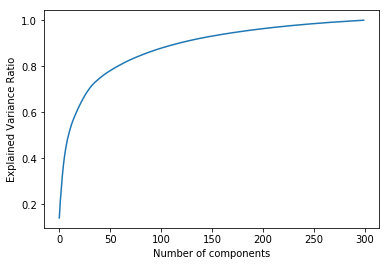

In [0]:
plt.plot(np.arange(0,300),cum_var_explained)
plt.xlabel("Number of components")
plt.ylabel("Explained Variance Ratio")

**N-COMPONENTS : 150**

In [0]:
tvd = TruncatedSVD(n_components=150,n_iter=50)
Usigma = tvd.fit_transform(co_matrix)

### 4. Applying k-means clustering

In [0]:
#creating the word-vectors for 150 dimension Latent Representation
Word_vectors = pd.DataFrame(Usigma,index=co_matrix.columns)
#determining the optimal number of clusters present in the word vectors using Elbow method 
wss = {}
for i in list(range(1,20)):
    km = KMeans(n_clusters=i,init="k-means++",n_init=5,algorithm='auto',n_jobs=-1)
    print("Running for k = " + str(i) + "\n")
    km.fit(Word_vectors)
    wss[i] = km.inertia_

Running for k = 1

Running for k = 2

Running for k = 3

Running for k = 4

Running for k = 5

Running for k = 6

Running for k = 7

Running for k = 8

Running for k = 9

Running for k = 10

Running for k = 11

Running for k = 12

Running for k = 13

Running for k = 14

Running for k = 15

Running for k = 16

Running for k = 17

Running for k = 18

Running for k = 19



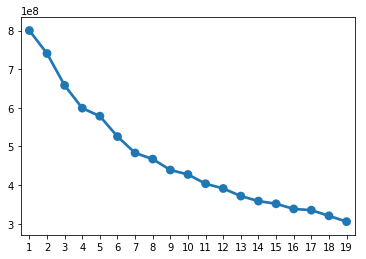

In [0]:
sns.pointplot(x=list(wss.keys()),y=list(wss.values()))

**K=3**

In [0]:
km = KMeans(n_clusters=5,init="k-means++",n_init=10,algorithm='auto',n_jobs=-1)
km.fit(Word_vectors)
Word_vectors['Clusters'] = km.predict(Word_vectors)

In [0]:
pd.value_counts(Word_vectors['Clusters'])

1    2995
0       2
3       1
4       1
2       1
Name: Clusters, dtype: int64

### 5. Wordclouds of clusters obtained in the above section

In [0]:
word_clusters = dict(zip(list(Word_vectors.index),list(Word_vectors['Clusters'])))

In [0]:
clusters = list(pd.unique(list(word_clusters.values())))
vals = {0:"",1:"",2:""}
for i,j in word_clusters.items():
    vals[j] = vals[j] + i + " "

**Cluster Label = 0**

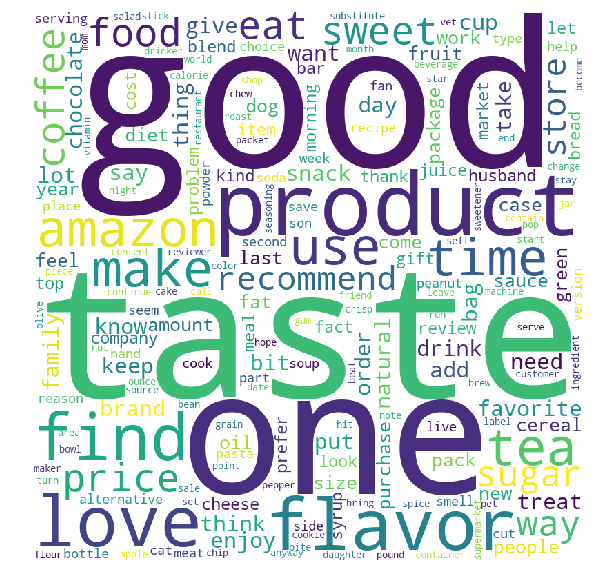

In [0]:
wc = wordcloud.WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(vals[0])
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

**Cluster Label =1**

In [0]:
word = {}
word[str(Word_vectors[Word_vectors['Clusters']==1].index.values[0])]=1

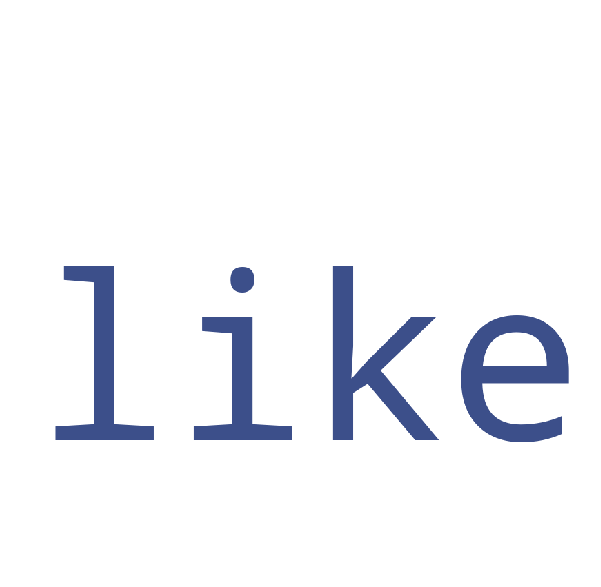

In [0]:
wc = wordcloud.WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(word)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

**Cluster Label=2**

In [0]:
word = {}
word[str(Word_vectors[Word_vectors['Clusters']==2].index.values[0])]=1

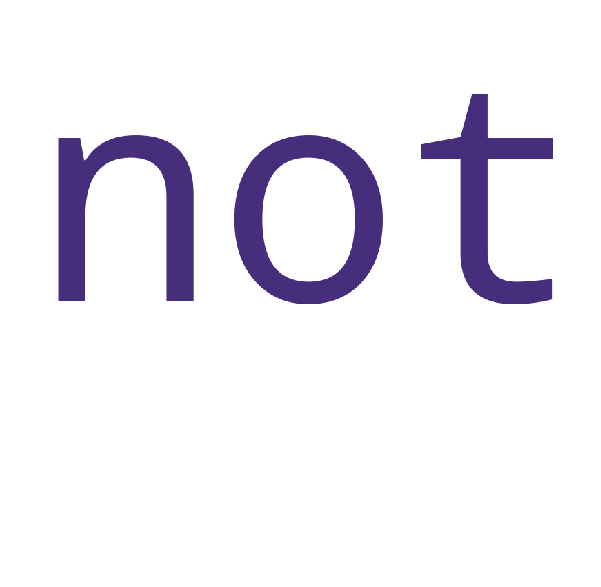

In [0]:
wc = wordcloud.WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(word)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 6. Function that returns most similar words for a given word.

In [0]:
#function that returns the most similar words using cosine similarity 
def similarWords(word,numberOfWords):
    #checking whether the word is there in Word_Vector or not

    if word in list(Word_vectors.index):
        
        similarities = {}
        vectors = list(Word_vectors.index)
        #removing the word from the vectors 
        vectors.remove(word)
        dimension = len(Word_vectors.columns)
        
        for j in vectors:
            cos_sim = cosine_similarity(Word_vectors.loc[word].values.reshape(1,dimension),Word_vectors.loc[j].values.reshape(1,dimension),dense_output=False)[0][0]
            similarities[j] = cos_sim
            
        top_N = {}
        for i in sorted(similarities.items(), key=operator.itemgetter(1),reverse=True)[:numberOfWords]:
              top_N[i[0]] = i[1]
                
        return top_N
        
    else:
        return "Word not in the list of vectors"
        

In [0]:
similarWords('cake',10)

{'brownie': 0.851556854234172,
 'cupcakes': 0.800316744358035,
 'pancake': 0.757323967025556,
 'waffle': 0.7446810103044081,
 'mix': 0.7391816640258995,
 'muffin': 0.7308221397101633,
 'trail': 0.7024081616842244,
 'frosting': 0.7012537312103229,
 'chunk': 0.6788304965049128,
 'cookie': 0.6787696344717029}

### 7.Conclusions

In [0]:
1. ** Like and Not ** which are two opposite words are completely seperated from each other into 2 different clusters. These two words significantly contribute in determining the polarity of the word.
2. All the other words are which play the parts such as adverbs,nouns etc are aggregated in one cluster. 